In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics as stat
from datetime import datetime as dt
sns.set()

from scipy import stats
from scipy.stats import norm
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn import preprocessing
from sklearn.feature_selection import f_regression

## 1. Features Engineering

### Based on observations of market information and research on the prices of HDB, the following are the assumed hypothesis on the key factors affecting the price of a HDB:

1. <b>Accessibility</b>: The distance between the apartment and the nearest public transport facilities, namely the MRT station.

2. <b>Apartment Details</b>: Storey, Flat Size, Flat Type

3. <b>Estate</b>: Matured towns are more likely to cost more as they are equipped with better and more complete facilities.

4. <b>Distance to Central</b>: As researched, houses which are nearer to the Central Business District Are are highly likely to cost more.

5. <b>Proximity to Amenities</b>: Distance between the apartment and the nearest shopping mall. Assumed that the shopping mall has the necessities of the family, buyers are more likely to pay more for the added ease of living.

## 2. Data Source

1. Resale prices of HDB from 1990 to 2020: https://data.gov.sg/dataset/resale-flat-prices

2. Geolocational Information: Extracted latitude and longitude of each flat, the nearest MRT station to the flat and nearest shopping malls with 'OneMap Singapore API' https://www.onemap.gov.sg/docs/ and Python Tool $Geopy$

3. List of MRT and LRT stations: https://www.lta.gov.sg/content/ltagov/en/getting_around/public_transport/rail_network.html

4. List of Shopping Centres: https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore



In [2]:
df_raw = pd.read_csv('resale-flat-prices-1990-2020_modified.csv')
df_raw.head()


D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,month,year,town,flat_type,flat_type_variable,block,street_name,storey_range,avg_storey_range,floor_area_sqm,...,resale_price,longitude,latitude,address,postal,nearest_mrt,distance_to_mrt,nearest_mall,distance_to_mall,distance_cbd
0,1993-09,1993,JURONG WEST,EXECUTIVE,6,906,JURONG WEST ST 91,07 TO 09,8,144.0,...,265000.0,103.685228,1.341221,906 JURONG WEST ST 91,640906,Pioneer MRT STATION,1.37677,Pioneer Mall,1.330529,19.554763
1,1993-09,1993,JURONG WEST,EXECUTIVE,6,906,JURONG WEST ST 91,10 TO 12,11,145.0,...,260000.0,103.685228,1.341221,906 JURONG WEST ST 91,640906,Pioneer MRT STATION,1.37677,Pioneer Mall,1.330529,19.554763
2,1993-10,1993,JURONG WEST,EXECUTIVE,6,906,JURONG WEST ST 91,01 TO 03,2,141.0,...,265000.0,103.685228,1.341221,906 JURONG WEST ST 91,640906,Pioneer MRT STATION,1.37677,Pioneer Mall,1.330529,19.554763
3,1993-11,1993,JURONG WEST,EXECUTIVE,6,906,JURONG WEST ST 91,07 TO 09,8,141.0,...,303000.0,103.685228,1.341221,906 JURONG WEST ST 91,640906,Pioneer MRT STATION,1.37677,Pioneer Mall,1.330529,19.554763
4,1993-11,1993,JURONG WEST,EXECUTIVE,6,906,JURONG WEST ST 91,10 TO 12,11,145.0,...,255000.0,103.685228,1.341221,906 JURONG WEST ST 91,640906,Pioneer MRT STATION,1.37677,Pioneer Mall,1.330529,19.554763


### 2.1 Data Cleaning

In [3]:
# remove duplicates
df_raw.drop_duplicates()

#check for missing values 

total = df_raw.isnull().sum().sort_values(ascending=False)
percent= (df_raw.isnull().sum()/df_raw.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
month,0,0.0
remaining_lease,0,0.0
distance_to_mall,0,0.0
nearest_mall,0,0.0
distance_to_mrt,0,0.0
nearest_mrt,0,0.0
postal,0,0.0
address,0,0.0
latitude,0,0.0
longitude,0,0.0


In [4]:
# Standardising values in flat types

df_raw['flat_type'] = df_raw['flat_type'].str.replace('MULTI-GENERATION', 'MULTI GENERATION')
df_raw.flat_type.value_counts()

4 ROOM              307971
3 ROOM              263685
5 ROOM              170043
EXECUTIVE            62637
2 ROOM                8987
1 ROOM                 589
MULTI GENERATION       502
Name: flat_type, dtype: int64

In [5]:
# Standardising values in flat model

rep_values = {'NEW GENERATION':'New Generation', 
                  'SIMPLIFIED':'Simplified', 
                  'STANDARD':'Standard', 
                  'MODEL A-MAISONETTE':'Maisonette', 
                  'MULTI GENERATION':'Multi Generation', 
                  'IMPROVED-MAISONETTE':'Executive Maisonette', 
                  'Improved-Maisonette':'Executive Maisonette', 
                  'Premium Maisonette':'Executive Maisonette', 
                  '2-ROOM':'2-room', 
                  'MODEL A':'Model A', 
                  'MAISONETTE':'Maisonette', 
                  'Model A-Maisonette':'Maisonette', 
                  'IMPROVED':'Improved', 'TERRACE':'Terrace', 
                  'PREMIUM APARTMENT':'Premium Apartment', 
                  'Premium Apartment Loft':'Premium Apartment', 
                  'APARTMENT':'Apartment', 
                  'Type S1':'Type S1S2', 
                  'Type S2':'Type S1S2'
                 }

df_raw = df_raw.replace({'flat_model': rep_values})

df_raw.flat_model.value_counts()

Model A                 228264
Improved                211213
New Generation          173652
Simplified               53869
Standard                 38001
Premium Apartment        35066
Apartment                32004
Maisonette               28798
Model A2                  9109
DBSS                      1609
Adjoined flat             1048
Terrace                    642
Multi Generation           502
Type S1S2                  401
Executive Maisonette       196
2-room                      40
Name: flat_model, dtype: int64

In [6]:
df_raw.town.unique()

array(['JURONG WEST', 'LIM CHU KANG', 'JURONG EAST', 'CHOA CHU KANG',
       'BUKIT BATOK', 'KALLANG/WHAMPOA', 'BUKIT PANJANG', 'CLEMENTI',
       'WOODLANDS', 'BUKIT TIMAH', 'QUEENSTOWN', 'BUKIT MERAH',
       'SEMBAWANG', 'YISHUN', 'BISHAN', 'ANG MO KIO', 'CENTRAL AREA',
       'TOA PAYOH', 'SERANGOON', 'SENGKANG', 'GEYLANG', 'HOUGANG',
       'PUNGGOL', 'BEDOK', 'MARINE PARADE', 'TAMPINES', 'PASIR RIS'],
      dtype=object)

In [7]:
# changing 'month' to DateTimeIndex format

df_raw['month'] = pd.DatetimeIndex(df_raw['month'])

df_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814414 entries, 0 to 814413
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   month                814414 non-null  datetime64[ns]
 1   year                 814414 non-null  int64         
 2   town                 814414 non-null  object        
 3   flat_type            814414 non-null  object        
 4   flat_type_variable   814414 non-null  int64         
 5   block                814414 non-null  object        
 6   street_name          814414 non-null  object        
 7   storey_range         814414 non-null  object        
 8   avg_storey_range     814414 non-null  int64         
 9   floor_area_sqm       814414 non-null  float64       
 10  flat_model           814414 non-null  object        
 11  lease_commence_date  814414 non-null  int64         
 12  remaining_lease      814414 non-null  int64         
 13  resale_price  

### 2.2 Inflation Adjustment with CPI

Inflation or deflation  adjustment is the process of removing the effect of price inflation from data. This adjustment helps to stabilize the variance of random or seasonal fluctuations and/or highlight cyclical patterns in the data.

In [8]:
df_cpi = pd.read_csv('CPI.csv')

# Compute Resale Price Adjusted for Inflation Using Consumer Price Index for Housing & Utilities
# https://www.singstat.gov.sg/find-data/search-by-theme/economy/prices-and-price-indices/latest-data
df_cpi['month'] = pd.to_datetime(df_cpi['month'], format='%Y %b') # to datetime
df_raw = df_raw.merge(df_cpi, on='month', how='left') 

df_raw['adj_price'] = ((df_raw['resale_price'] / df_raw['cpi']) * 100).round(2)

In [9]:
df_raw = df_raw[['month', 'year', 'town', 'flat_type', 'flat_type_variable', 'block',
       'street_name', 'storey_range', 'avg_storey_range', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'remaining_lease', 
       'longitude', 'latitude', 'address', 'postal', 'nearest_mrt',
       'distance_to_mrt', 'nearest_mall', 'distance_to_mall', 'distance_cbd', 'resale_price',
       'cpi', 'adj_price']]

df_raw.sort_index()
df_raw.sort_values(by=['month','town','flat_type_variable'])

,month,year,town,flat_type,flat_type_variable,block,street_name,storey_range,avg_storey_range,floor_area_sqm,...,address,postal,nearest_mrt,distance_to_mrt,nearest_mall,distance_to_mall,distance_cbd,resale_price,cpi,adj_price
359801,1990-01-01,1990,ANG MO KIO,3 ROOM,3,601,ANG MO KIO AVE 5,01 TO 03,2,67.0,...,601 ANG MO KIO AVE 5,560601,Yio Chu Kang MRT STATION,1.064294,Broadway Plaza,1.569306,10.890449,47200.0,60.894,77511.74
362391,1990-01-01,1990,ANG MO KIO,3 ROOM,3,117,ANG MO KIO AVE 4,04 TO 06,5,74.0,...,117 ANG MO KIO AVE 4,560117,Yio Chu Kang MRT STATION,1.349139,Broadway Plaza,1.167302,10.083373,37000.0,60.894,60761.32
363387,1990-01-01,1990,ANG MO KIO,3 ROOM,3,603,ANG MO KIO AVE 5,07 TO 09,8,67.0,...,603 ANG MO KIO AVE 5,560603,Yio Chu Kang MRT STATION,1.008925,Broadway Plaza,1.456657,10.787348,46500.0,60.894,76362.20
364425,1990-01-01,1990,ANG MO KIO,3 ROOM,3,604,ANG MO KIO AVE 5,07 TO 09,8,67.0,...,604 ANG MO KIO AVE 5,560604,Yio Chu Kang MRT STATION,0.992765,Broadway Plaza,1.414385,10.746911,47000.0,60.894,77183.30
369134,1990-01-01,1990,ANG MO KIO,3 ROOM,3,235,ANG MO KIO AVE 3,10 TO 12,11,67.0,...,235 ANG MO KIO AVE 3,560235,Ang Mo Kio MRT STATION,1.458248,Broadway Plaza,1.194847,9.315810,38000.0,60.894,62403.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432093,2020-09-01,2020,YISHUN,5 ROOM,5,431A,YISHUN AVE 1,01 TO 03,2,112.0,...,431A YISHUN AVE 1,761431,Khatib MRT STATION,1.582357,Wisteria Mall,0.694389,15.009283,450000.0,99.869,450590.27
433020,2020-09-01,2020,YISHUN,5 ROOM,5,428A,YISHUN AVE 11,13 TO 15,14,112.0,...,428A YISHUN AVE 11,761428,Yishun MRT STATION,1.532246,Wisteria Mall,0.853432,15.331598,528888.0,99.869,529581.75
433021,2020-09-01,2020,YISHUN,5 ROOM,5,428A,YISHUN AVE 11,13 TO 15,14,112.0,...,428A YISHUN AVE 11,761428,Yishun MRT STATION,1.532246,Wisteria Mall,0.853432,15.331598,525000.0,99.869,525688.65
352848,2020-09-01,2020,YISHUN,EXECUTIVE,6,791,YISHUN AVE 2,04 TO 06,5,146.0,...,791 YISHUN AVE 2,760791,Khatib MRT STATION,0.293856,Wisteria Mall,0.903148,15.233830,558000.0,99.869,558731.94


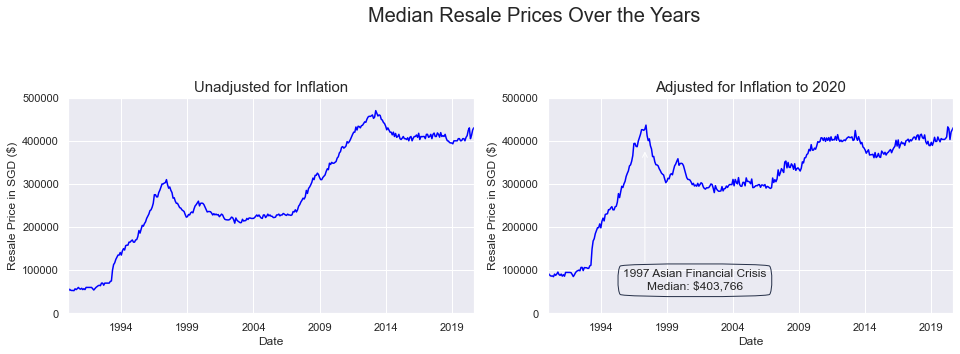

In [10]:
# Plot Median Resale Prices Over the Years

# Unadjusted
fig1 = plt.figure(figsize=(15,5))
fig1.suptitle('Median Resale Prices Over the Years', fontsize=20)
ax1 = fig1.add_subplot(121)
df_raw.groupby('month')[['resale_price']].median().plot(ax=ax1, color='blue', legend=None)
ax1.set_xlabel('Date'), ax1.set_ylabel('Resale Price in SGD ($)'), ax1.set_ylim(0, 500000), ax1.set_title('Unadjusted for Inflation', size=15)

# Adjusted
# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.

ax2 = fig1.add_subplot(122)
df_raw.groupby('month')[['adj_price']].median().plot(ax=ax2, color='blue', legend=None)
ax2.set_xlabel('Date'), ax2.set_ylabel('Resale Price in SGD ($)'), ax2.set_ylim(0, 500000), ax2.set_title('Adjusted for Inflation to 2020',size=15)
ax2.annotate('1997 Asian Financial Crisis\nMedian: $403,766', xy=('1997-05-01',380000), xycoords='data', 
    bbox=dict(boxstyle="round4,pad=.5", fc="none", ec="#28324a"), xytext=(50,-140), textcoords='offset points', ha='center',
    arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=90,rad=20"))
plt.tight_layout(rect=[0, 0, 0.9, 0.9]) 

plt.show()


In [11]:
df_raw.to_csv('hdb_dataset_prep.csv')

## 3. Exploratory Data Analysis

In [12]:
df_raw.describe(include='all')

C:\Users\edge\AppData\Local\Temp/ipykernel_7748/104216429.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_raw.describe(include='all')


,month,year,town,flat_type,flat_type_variable,block,street_name,storey_range,avg_storey_range,floor_area_sqm,...,address,postal,nearest_mrt,distance_to_mrt,nearest_mall,distance_to_mall,distance_cbd,resale_price,cpi,adj_price
count,814414,814414.000000,814414,814414,814414.000000,814414,814414,814414,814414.000000,814414.000000,...,814414,814414,814414,814414.000000,814414,814414.000000,814414.000000,8.144140e+05,814414.000000,8.144140e+05
unique,369,NaN,27,7,NaN,2454,554,25,NaN,NaN,...,9145,9149,126,NaN,112,NaN,NaN,NaN,NaN,NaN
top,1999-03-01 00:00:00,NaN,TAMPINES,4 ROOM,NaN,2,YISHUN RING RD,04 TO 06,NaN,NaN,...,211 BOON LAY PL,640185,Yishun MRT STATION,NaN,West Mall,NaN,NaN,NaN,NaN,NaN
freq,6352,NaN,73101,307971,NaN,4058,16210,206555,NaN,NaN,...,791,734,41207,NaN,38286,NaN,NaN,NaN,NaN,NaN
first,1990-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2004.322368,NaN,NaN,4.016450,NaN,NaN,NaN,7.547446,95.997997,...,NaN,NaN,NaN,0.624788,NaN,0.729347,12.069459,2.958013e+05,82.606336,3.494865e+05
std,NaN,7.920209,NaN,NaN,0.946643,NaN,NaN,NaN,4.628766,25.904459,...,NaN,NaN,NaN,0.377553,NaN,0.419665,4.370973,1.482143e+05,14.579650,1.503106e+05
min,NaN,1990.000000,NaN,NaN,1.000000,NaN,NaN,NaN,2.000000,31.000000,...,NaN,NaN,NaN,0.015819,NaN,0.000000,0.587978,5.000000e+03,60.894000,8.003070e+03
25%,NaN,1998.000000,NaN,NaN,3.000000,NaN,NaN,NaN,5.000000,73.000000,...,NaN,NaN,NaN,0.346189,NaN,0.407586,9.147559,1.850000e+05,72.548000,2.443601e+05


### 3.1 Month

The feature 'month' contains the year and month of the sale.

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


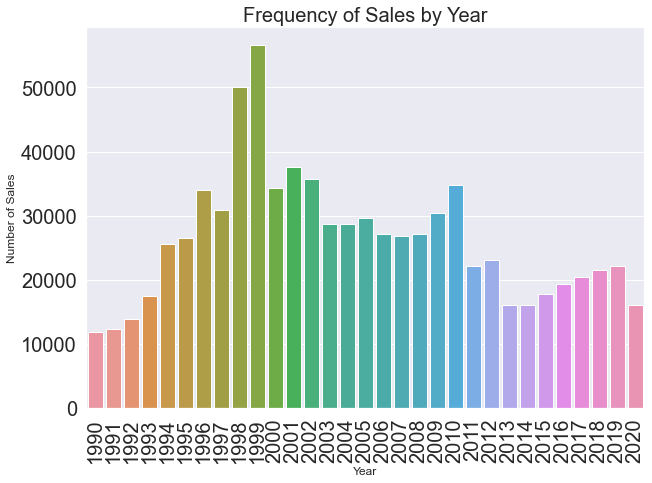

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


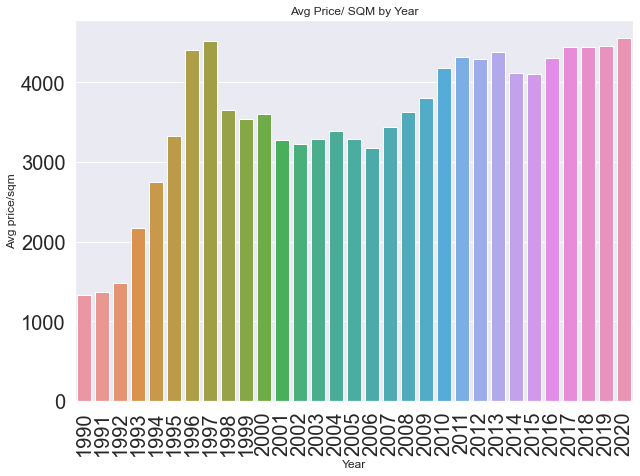

In [13]:
#yearly sales trend

sales_year = np.unique(pd.DatetimeIndex(df_raw['month']).year.values)
year_count = pd.DatetimeIndex(df_raw['month']).year.value_counts()

sns.barplot(year_count.index, year_count.values, order=sales_year)
plt.ylabel('Number of Sales', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.gcf().set_size_inches((10, 7)) 
plt.xticks(fontsize= 20, rotation='vertical')
plt.yticks(fontsize= 20)
plt.title("Frequency of Sales by Year", fontsize=20)
plt.show()


#sales year vs avg price/sqm

n = len(sales_year)
avg_price = np.zeros(n)

for i in range(0,n):
        price = df_raw['adj_price'][pd.DatetimeIndex(df_raw['month']).year == sales_year[i]].sum()
        sqmm = df_raw['floor_area_sqm'][pd.DatetimeIndex(df_raw['month']).year == sales_year[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(sales_year,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.gcf().set_size_inches((10, 7)) 
plt.xticks(fontsize= 20, rotation='vertical')
plt.yticks(fontsize= 20)
plt.title("Avg Price/ SQM by Year", fontsize=12)
plt.show()

1. Number of sales rose between 1990 and 1999 and then continuously dropped to around 15,000 in 2020.
2. As expected, due to rising housing prices and inflation, prices per sqm increase over time.
3. However there was a dip after 1997 and after 2013, the former was due to the financial crisis in 1997 and latter due to the cooling measures by MAS effective 13 Jan 2013.
4. The effect wears off around 2016, and prices rose and rising till 2020.

### 3.2 Flat Type

#### 3.2.1 Floor Area and Flat Type

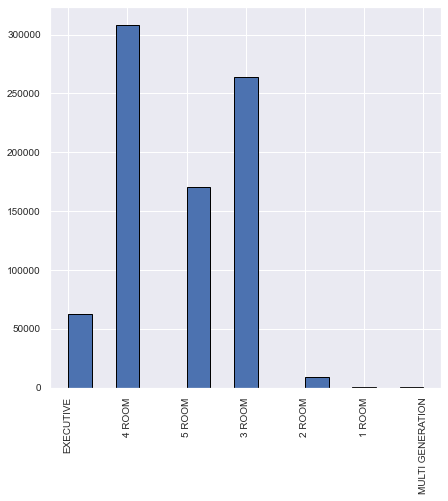

4 ROOM              307971
3 ROOM              263685
5 ROOM              170043
EXECUTIVE            62637
2 ROOM                8987
1 ROOM                 589
MULTI GENERATION       502
Name: flat_type, dtype: int64

In [14]:
plt.hist(df_raw['flat_type'], bins=15, edgecolor = 'black')
plt.gcf().set_size_inches((7, 7))  
plt.xticks(fontsize=10, rotation=90 )
plt.yticks(fontsize=10 )
plt.show()

display((df_raw['flat_type']).value_counts())

As reflected by the histogram above, 'Multi Generation', '1 Room' and '2 Room' flats made up a small portion of the entire resale population. Therefore, these will be removed from the dataset.

In [15]:
flat_drop = ['1 ROOM',
             '2 ROOM',
             'MULTI GENERATION'
             ]

df_new = df_raw[~df_raw.flat_type.isin(flat_drop)]

df_new.flat_type.value_counts()

4 ROOM       307971
3 ROOM       263685
5 ROOM       170043
EXECUTIVE     62637
Name: flat_type, dtype: int64

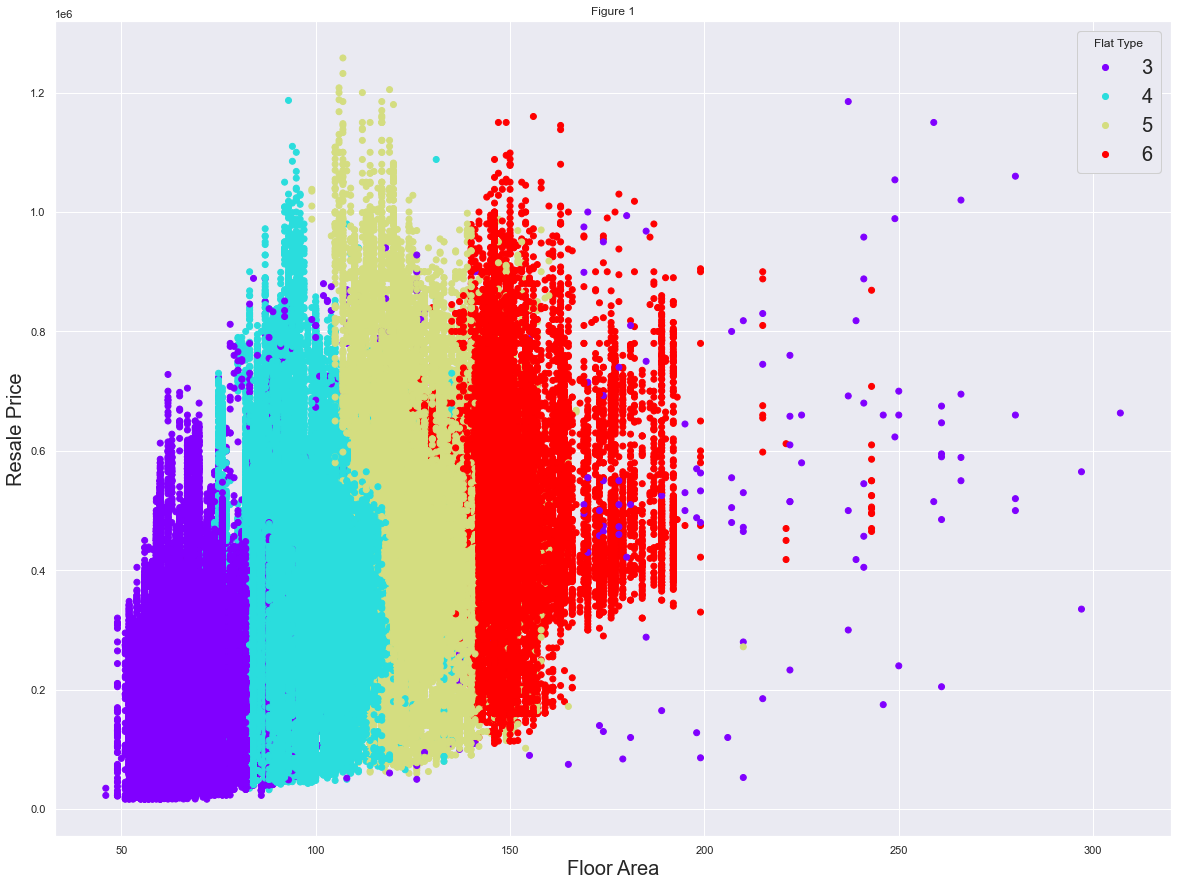

In [16]:
fig, ax = plt.subplots()
scatter = plt.scatter(df_new['floor_area_sqm'], df_new['resale_price'],c= df_new['flat_type_variable'], cmap='rainbow')
plt.xlabel('Floor Area',fontsize=20)
plt.ylabel('Resale Price',fontsize=20)

legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Flat Type",
                   fontsize = 20)
ax.add_artist(legend)

plt.gcf().set_size_inches((20, 15))  
plt.title('Figure 1')
plt.show()

In [17]:
area_median = df_new.groupby(['floor_area_sqm'])['adj_price'].apply(np.median)
area_median = pd.DataFrame(area_median)
area_median.reset_index(level=0, inplace=True)
x_area = area_median['floor_area_sqm']
y_area = area_median['adj_price']

In [18]:
x_area.shape
x_area_matrix = x_area.values.reshape(190,1)

In [19]:
reg_sqm = LinearRegression()
reg_sqm.fit(x_area_matrix,y_area)

print(reg_sqm.score(x_area_matrix,y_area))
print(reg_sqm.coef_)
print(reg_sqm.intercept_)

0.8275534695845344
[3266.68413968]
25152.409838239953


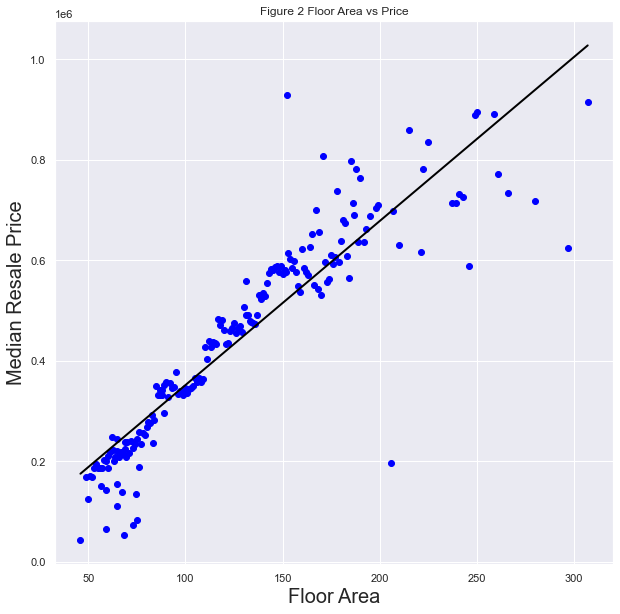

In [20]:
plt.scatter(area_median['floor_area_sqm'], area_median['adj_price'],color='blue')

yhat_sqm = reg_sqm.coef_*x_area_matrix + reg_sqm.intercept_
fig_sqm= plt.plot(x_area_matrix,yhat_sqm, lw=2, c='black', label = 'regression line')

plt.xlabel('Floor Area',fontsize=20)
plt.ylabel('Median Resale Price',fontsize=20)

plt.gcf().set_size_inches((10, 10))  
plt.title('Figure 2 Floor Area vs Price')
plt.show()

As we hypothesized, from the 2 graphs showing the relationship between Floor Area and Resale Price, we can certainly tell that there is a strong correlation between these 2 variables. The regression line plotted in Figure 2 shows an almost 45 degree inclination. Therefore, we can say with certain that bigger flat = higher price.

#### 3.2.2 Flat Model

As compared to 'flat_type', 'flat_model' is more specific description of the flat. There are in total 14 different 'flat_model' entries.

In [21]:
df_new.flat_model.unique()

array(['Apartment', 'Maisonette', 'Model A', 'Improved', 'Simplified',
       'New Generation', 'Premium Apartment', 'Model A2', 'Adjoined flat',
       'Standard', 'DBSS', 'Executive Maisonette', 'Terrace', 'Type S1S2'],
      dtype=object)

#### Types of Flat Models:

<b>Standard</b>: (1/2/3/4/5-room). 1960s HDB. Had WC and shower in same room. 5-room Standard were introduced in 1974.

<b>Improved</b>: (1/2/3/4/5-room). Introduced in 1966, the 3/4-room having separate WC and shower, they also featured void decks. 5-room Improved were introduced in 1974.

<b>New Generation</b>: Started first in 1975, New Generation flats can be 3-Room (67 / 82 sqm) or 4-Room (92 sqm), featuring en-suite toilet for master bedroom, with pedestal type Water Closet, plus store room.
Model A: Introduced in 1981: 3-Room (75 sqm), 4-Room (105 sqm), 5-Room (135 sqm), 5-Room Maisonette (139 sqm)

<b>Model A2</b>: Smaller units of Model A. e.g., 4-Room Model A2 (90 sqm)

<b>Simplified</b>: Introduced in 1984: 3-Room (64 sqm), 4-Room (84 sqm)

<b>Multi Generation</b>: 3Gen flats designed to meet the needs of multi-generation families.

<b>Maisonette</b>: AKA Model A Maisonette — 2 storeys HDB flat

<b>Premium Apartment</b>: Introduced somewhere during 1990s, featuring better quality finishes, you get them in ready-to-move condition, with flooring, kitchen cabinets, built-in wardrobes

<b>Executive Maisonette</b>: More premium version of Model A Maisonettes. These units are no longer being built after being replaced by the Executive Condominium (EC) scheme in 1995

<b>Executive Apartment</b>: Executive Apartment / Maisonette (146-150 sqm) were introduced in 1983 and replaced 5-Room Model A flats, in addition of the 3-bedroom and separate living/dining found in 5A flats, EA and EM feature an utility/maid room. 80% of Executive units were Maisonettes and 20% were Apartments.

<b>DBBS</b>: public apartments built under the HDB's short-lived Design, Build and Sell Scheme (DBSS) from 2005 to 2012. They are a unique (and premium) breed of HDB flats in Singapore, which are built by private developers. High Prices. Quite similiar to Executive Condominium except DBBS is like a premium HDB without facilities of private condos

<b>Adjoined Flat</b>: Large HDB flats which are combined from 2 HDB flats

<b>Terrace</b>: HDB terrace flats built before HDB, without realizing Singapore's land constraint. Discontinued

<b>Type S1S2</b>: apartments at The Pinnacle@Duxton are classified as "S" or Special apartments in view of its historical significance and award-winning design. For application of HDB policies, S1 and S2 apartments will be treated as 4-room and 5-room flats respectively

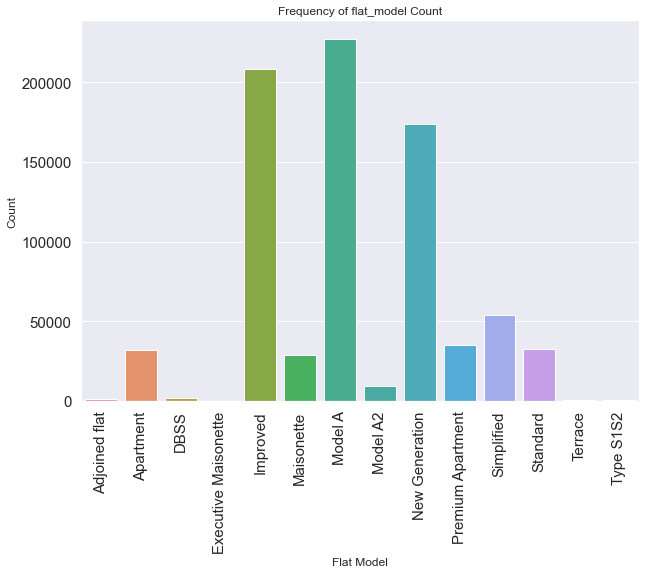

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


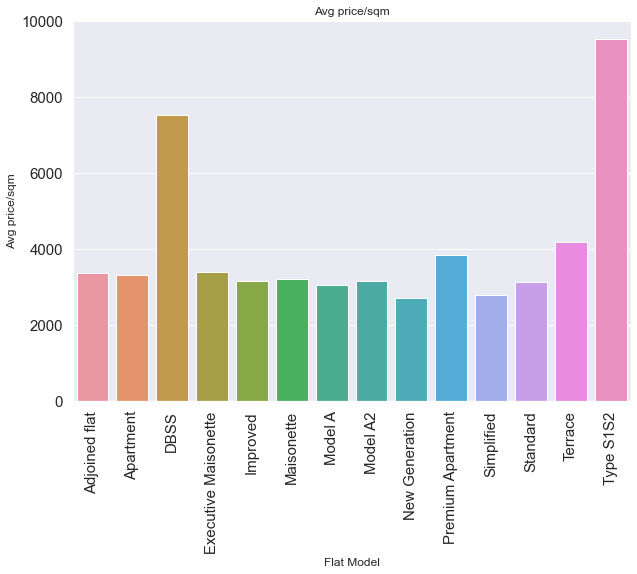

In [22]:
#flat_model count

count_model = df_new['flat_model'].nunique()
#flat_model_count = data['flat_model'].value_counts()
#print("Flat Model Count \n" +str(flat_model_count))

flat_model = np.unique(df_new['flat_model'])

sns.countplot(x="flat_model", data=df_new , order = flat_model)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Flat Model', fontsize=12)
plt.xticks(fontsize= 15, rotation='vertical')
plt.yticks(fontsize= 15)
plt.gcf().set_size_inches((10, 7)) 
plt.title("Frequency of flat_model Count", fontsize=12)
plt.show()

#flat model vs avg price/sqm
n = len(flat_model)
avg_price = np.zeros(n)

for i in range(0,n):
        price = df_new['resale_price'][df_new['flat_model'] == flat_model[i]].sum()
        sqmm = df_new['floor_area_sqm'][df_new['flat_model'] == flat_model[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(flat_model,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Flat Model', fontsize=12)
plt.xticks(fontsize= 15, rotation='vertical')
plt.yticks(fontsize= 15)
plt.gcf().set_size_inches((10, 7)) 
plt.title("Avg price/sqm", fontsize=12)
plt.show()

#### 3.2.3 Storey

In [23]:
floor_median = df_new.groupby(['avg_storey_range'])['adj_price'].apply(np.median)
floor_median = pd.DataFrame(floor_median)
floor_median.reset_index(level=0, inplace=True)

x_floor = floor_median['avg_storey_range']
y_floor = floor_median['adj_price']

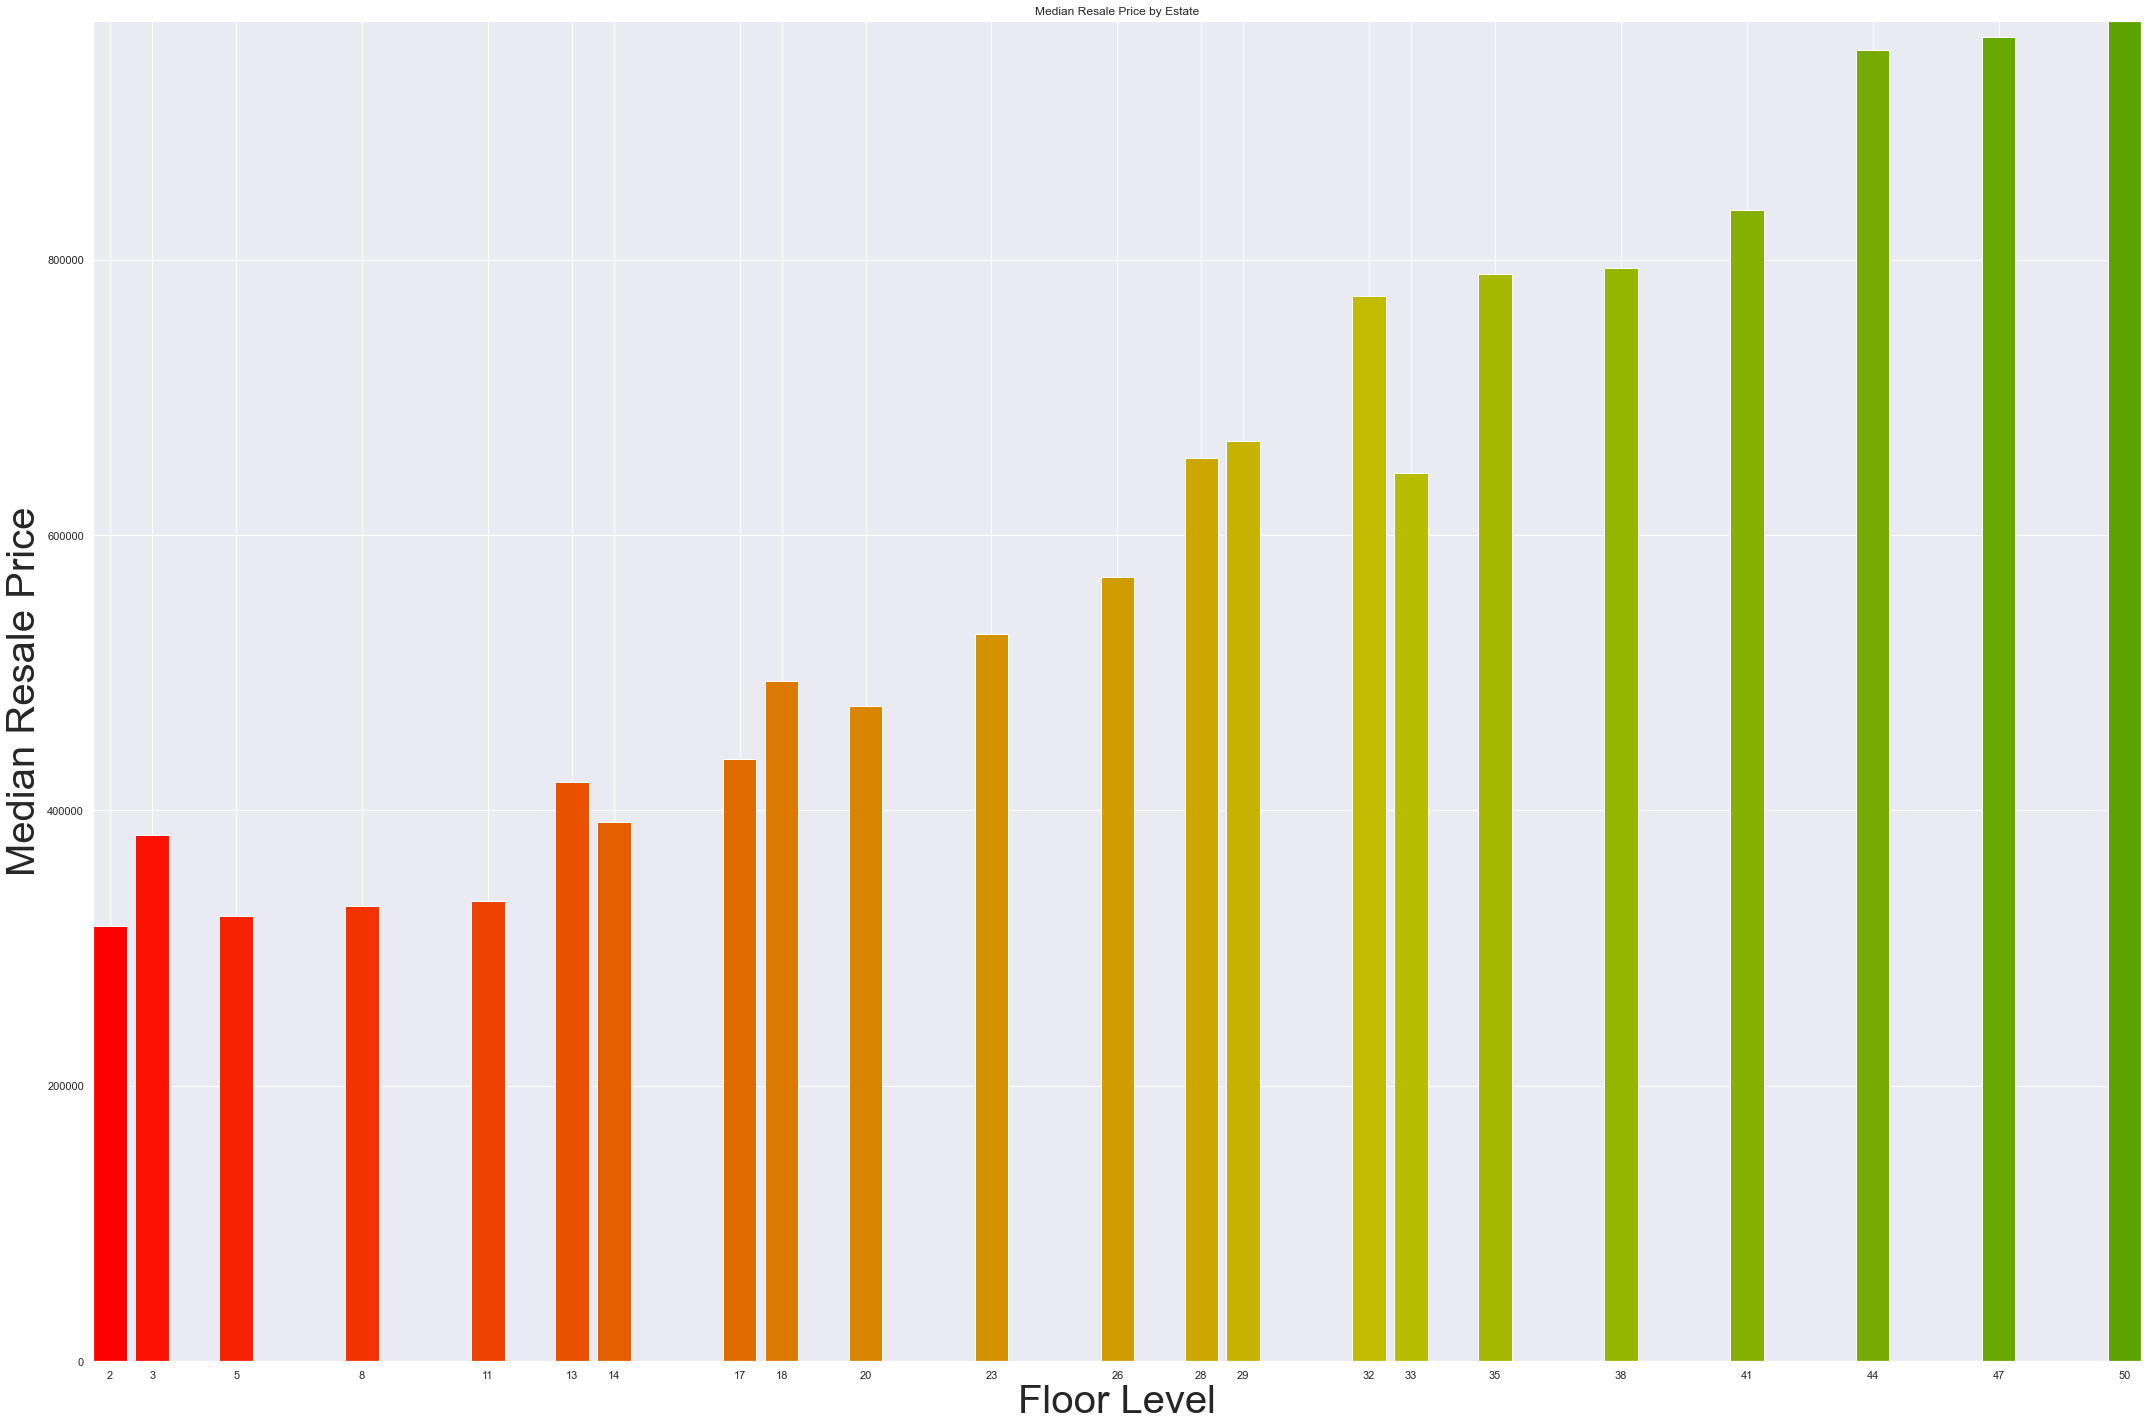

In [24]:
from colour import Color

red = Color("red")
colors = list(red.range_to(Color("green"), 30))
colors = [color.rgb for color in colors]

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.figure(figsize = (30,20))
plt.bar(x_floor, y_floor, color = colors)
plt.xlabel("Floor Level",size= 40)
plt.ylabel("Median Resale Price", fontsize= 40)
plt.margins(x=0, y=0)
plt.xticks(x_floor)
plt.title("Median Resale Price by Estate")
plt.show()

From the bar chart above, we can tell that high floors usually fetches a higher selling price. Especially true, when the flat is level 14 and higher.

### 3.3 Estate

In [25]:
# es_median = df_new.groupby(['flat_type', 'town'])['adj_price'].apply(np.median)
# es_median = pd.DataFrame(es_median)
# es_median.reset_index(level=0, inplace=True)
# es_median['town'] = es_median.index
# es_median.reset_index(drop=True, inplace=True)
# es_median

Total Town Count: 27


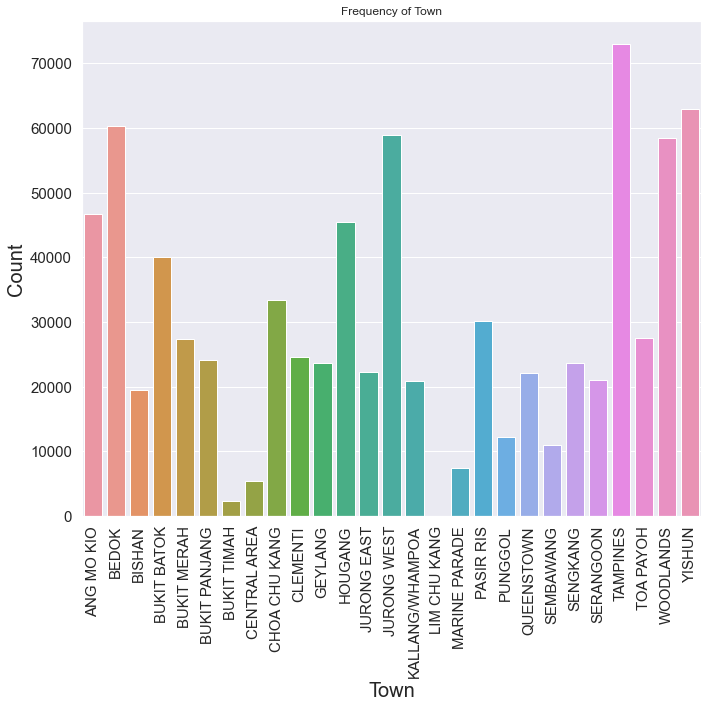

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


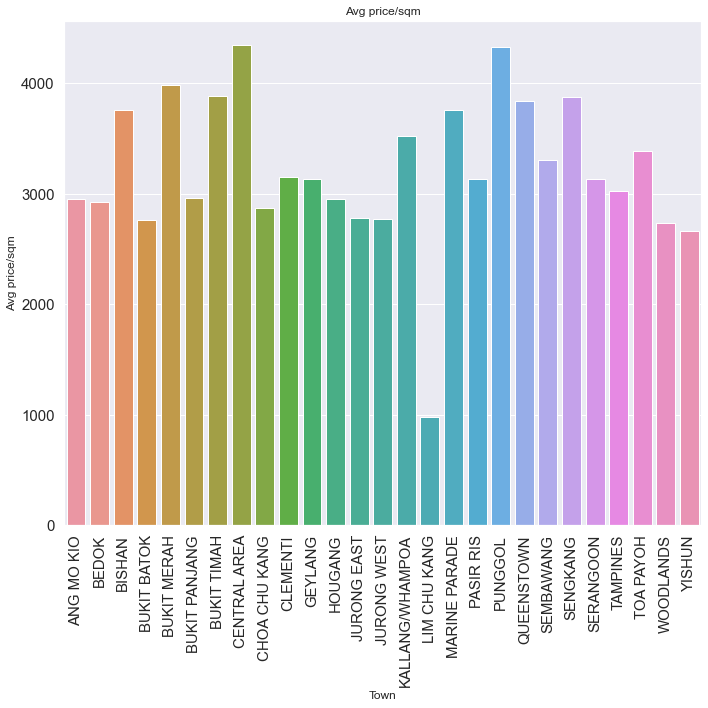

In [26]:
count_towns = df_new['town'].nunique()
print("Total Town Count:", count_towns)

town = np.unique(df_new['town'])


sns.countplot(x="town", data=df_new , order = town)
plt.ylabel('Count', fontsize=20)
plt.xlabel('Town', fontsize=20)
plt.xticks(fontsize= 15, rotation='vertical')
plt.yticks(fontsize= 15)
plt.gcf().set_size_inches((10, 10)) 
plt.title("Frequency of Town", fontsize=12)
plt.show()

#town vs avg price/sqm
n = len(town)
avg_price = np.zeros(n)

for i in range(0,n):
        price = df_new['resale_price'][df_new['town'] == town[i]].sum()
        sqmm = df_new['floor_area_sqm'][df_new['town'] == town[i]].sum()
        priceSQM = price/sqmm
        avg_price[i] = priceSQM
        
sns.barplot(town,avg_price)
plt.ylabel('Avg price/sqm', fontsize=12)
plt.xlabel('Town', fontsize=12)
plt.xticks(fontsize= 15, rotation='vertical')
plt.yticks(fontsize= 15)
plt.gcf().set_size_inches((10, 10)) 
plt.title("Avg price/sqm", fontsize=12)
plt.show()

Observations:

1. Besides Bukit Timah and Lim Chu Kang, all towns have more than 5,000 sales from 1990 to 2020.
2. Tampines is the most present town, with over 70,000 sales.
3. Lim Chu Kang has the lowest avg price/ sqm (less than SGD 1000). Upon research, the entire Lim Chu Kang estate was en-bloc on 2002. Therefore, Lim Chu Kang will be removed from our dataset.
4. Punggol and Senkang, located far off central fetches the highest resale price. After looking at the data, it shows that Punggol and Sengkang wasrecently developed in the last 10 years, which means that the initial pricing is already high.
5. The next 5 towns with the highest price are Central, Bukit Merah, Bukit Timah, Queenstown and Bishan. Unsurprisingly, these areas are located near Central, therefore fetches a higher price.


In [27]:
df_new = df_new.loc[df_new['town'] != 'LIM CHU KANG']
df_new.town.value_counts()

TAMPINES           72929
YISHUN             62953
BEDOK              60314
JURONG WEST        58862
WOODLANDS          58430
ANG MO KIO         46744
HOUGANG            45441
BUKIT BATOK        40017
CHOA CHU KANG      33353
PASIR RIS          30227
TOA PAYOH          27545
BUKIT MERAH        27400
CLEMENTI           24631
BUKIT PANJANG      24192
GEYLANG            23680
SENGKANG           23598
JURONG EAST        22283
QUEENSTOWN         22057
SERANGOON          21055
KALLANG/WHAMPOA    20893
BISHAN             19431
PUNGGOL            12206
SEMBAWANG          10956
MARINE PARADE       7380
CENTRAL AREA        5443
BUKIT TIMAH         2283
Name: town, dtype: int64

### 3.4 Distance to CBD

In [28]:
cbd_median1 = df_new.groupby(['town'])[['adj_price']].apply(np.median)
cbd_median2 = df_new.groupby(['town'])[['distance_cbd']].apply(np.median)
cbd_median1.name = 'median_price'
cbd_median2.name = 'median_dis'

cbd_median1 = pd.DataFrame(cbd_median1)
cbd_median2 = pd.DataFrame(cbd_median2)

cbd_median = cbd_median1.join(cbd_median2, on=['town'])

cbd_median['town'] = cbd_median.index
cbd_median.reset_index(drop=True, inplace=True)
cbd_median

,median_price,median_dis,town
0,271910.240,9.618541,ANG MO KIO
1,289350.595,10.039705,BEDOK
2,473503.790,7.523915,BISHAN
3,285291.200,13.767870,BUKIT BATOK
4,347666.565,3.401272,BUKIT MERAH
5,340484.625,14.179059,BUKIT PANJANG
6,496686.490,10.444139,BUKIT TIMAH
7,333992.090,1.625216,CENTRAL AREA
8,371206.060,16.434630,CHOA CHU KANG
9,290710.350,10.129475,CLEMENTI


In [29]:
# Group Town by Regions

town_region = {'ANG MO KIO':'North East',
               'BEDOK':'East', 'BISHAN':'Central',
               'BUKIT BATOK':'West',
               'BUKIT MERAH':'Central', 
               'BUKIT PANJANG':'West',
               'BUKIT TIMAH':'Central',
               'CENTRAL AREA':'Central',
               'CHOA CHU KANG':'West', 
               'CLEMENTI':'West',
               'GEYLANG':'Central',
               'HOUGANG':'North East',
               'JURONG EAST':'West',
               'JURONG WEST':'West', 
               'QUEENSTOWN':'Central',
               'SEMBAWANG':'North',
               'SENGKANG':'North East',
               'SERANGOON':'North East',
               'TAMPINES':'East', 
               'TOA PAYOH':'Central',
               'WOODLANDS':'North',
               'YISHUN':'North',
               'KALLANG/WHAMPOA': 'Central',
               'MARINE PARADE' : 'Central',
               'PASIR RIS' : 'East',
               'PUNGGOL' : 'North East'
              }

cbd_median['region'] = cbd_median['town'].map(town_region)
colors = {'North East':'purple', 'East': 'green', 'Central':'orange', 'West':'blue', 'North':'red'}
cbd_median['colors'] = cbd_median['region'].map(colors)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


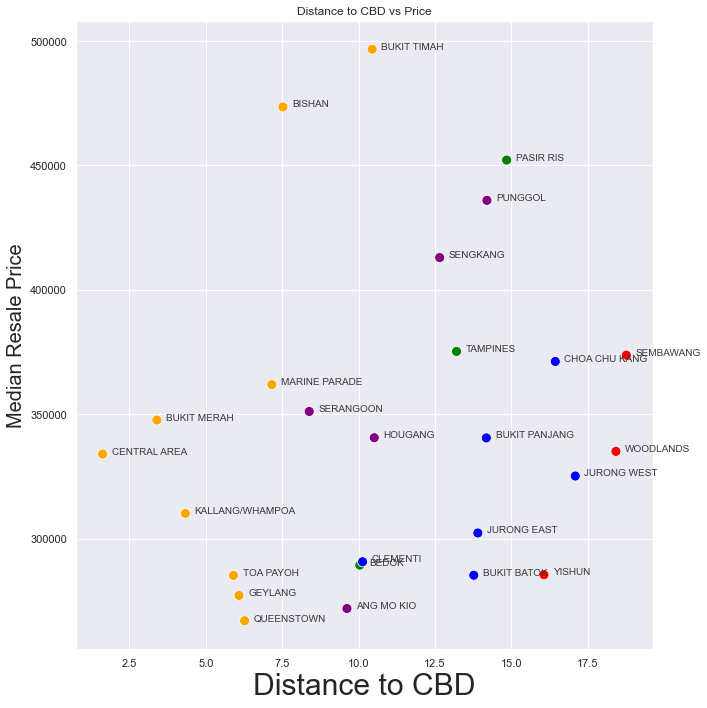

In [30]:
fig, ax = plt.subplots(figsize=(12.5, 8))

sns.scatterplot(cbd_median['median_dis'], cbd_median['median_price'], s= 100, c=cbd_median['colors'])

# yhat_sqm = reg_sqm.coef_*x_area_matrix + reg_sqm.intercept_
# fig_sqm= plt.plot(x_area_matrix,yhat_sqm, lw=2, c='black', label = 'regression line')

plt.xlabel('Distance to CBD',fontsize=30)
plt.ylabel('Median Resale Price',fontsize=20)

plt.gcf().set_size_inches((10, 10))  
plt.title('Distance to CBD vs Price')

for i, txt in enumerate(cbd_median['town']):
    ax.annotate(txt, (cbd_median['median_dis'][i]+0.3, cbd_median['median_price'][i]), size=10, alpha=0.9)
    
plt.show()

Data from this plot stretches far back to 1990, where the prices of housing are low. Therefore creating an unfairly skewed graph. To only include dataset from the past 10 years, 2011 to 2020.

In [31]:
years20 = list(range(1990,2011))
df_new = df_raw[~df_raw.year.isin(years20)]
df_new.year.value_counts()

2012    23133
2011    22184
2019    22140
2018    21504
2017    20459
2016    19332
2015    17741
2020    16090
2014    16060
2013    16058
Name: year, dtype: int64

In [32]:
cbd_median1 = df_new.groupby(['town'])[['adj_price']].apply(np.median)
cbd_median2 = df_new.groupby(['town'])[['distance_cbd']].apply(np.median)
cbd_median1.name = 'median_price'
cbd_median2.name = 'median_dis'

cbd_median1 = pd.DataFrame(cbd_median1)
cbd_median2 = pd.DataFrame(cbd_median2)

cbd_median = cbd_median1.join(cbd_median2, on=['town'])

cbd_median['town'] = cbd_median.index
cbd_median.reset_index(drop=True, inplace=True)

town_region = {'ANG MO KIO':'North East',
               'BEDOK':'East', 'BISHAN':'Central',
               'BUKIT BATOK':'West',
               'BUKIT MERAH':'Central', 
               'BUKIT PANJANG':'West',
               'BUKIT TIMAH':'Central',
               'CENTRAL AREA':'Central',
               'CHOA CHU KANG':'West', 
               'CLEMENTI':'West',
               'GEYLANG':'East',
               'HOUGANG':'North East',
               'JURONG EAST':'West',
               'JURONG WEST':'West', 
               'QUEENSTOWN':'Central',
               'SEMBAWANG':'North',
               'SENGKANG':'North East',
               'SERANGOON':'North East',
               'TAMPINES':'East', 
               'TOA PAYOH':'Central',
               'WOODLANDS':'North',
               'YISHUN':'North',
               'KALLANG/WHAMPOA': 'Central',
               'MARINE PARADE' : 'Central',
               'PASIR RIS' : 'East',
               'PUNGGOL' : 'North East'
              }

cbd_median['region'] = cbd_median['town'].map(town_region)
colors = {'North East':'purple', 'East': 'green', 'Central':'orange', 'West':'blue', 'North':'red'}
cbd_median['colors'] = cbd_median['region'].map(colors)

In [33]:
x_cbd = cbd_median['median_dis'].values.reshape(-1,1)

D:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


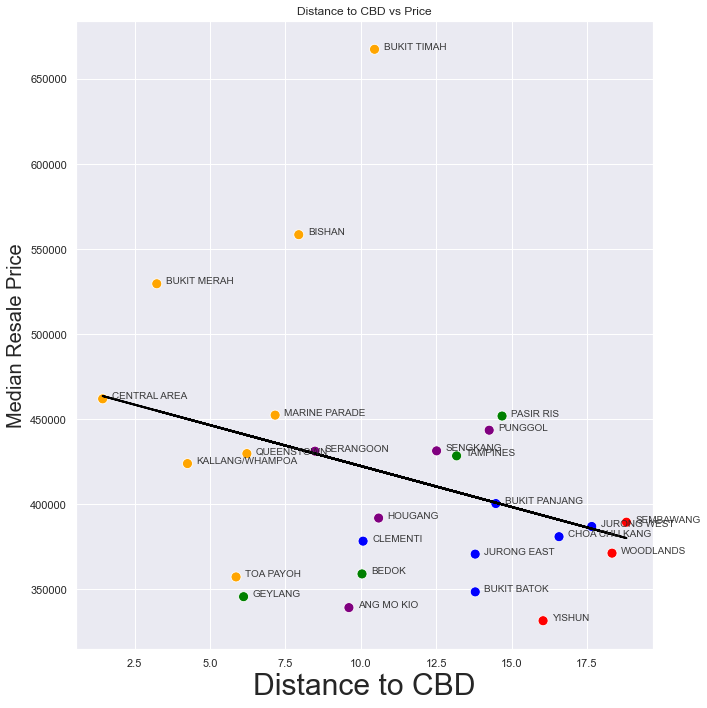

In [34]:
reg_cbd = LinearRegression()
reg_cbd.fit(x_cbd, cbd_median['median_price'])


fig, ax = plt.subplots(figsize=(12.5, 8))

sns.scatterplot(cbd_median['median_dis'], cbd_median['median_price'], s= 100, c=cbd_median['colors'])

yhat_cbd = reg_cbd.coef_*x_cbd + reg_cbd.intercept_
fig_cbd = plt.plot(x_cbd,yhat_cbd, lw=2, c='black', label = 'regression line')

plt.xlabel('Distance to CBD',fontsize=30)
plt.ylabel('Median Resale Price',fontsize=20)

plt.gcf().set_size_inches((10, 10))  
plt.title('Distance to CBD vs Price')

for i, txt in enumerate(cbd_median['town']):
    ax.annotate(txt, (cbd_median['median_dis'][i]+0.3, cbd_median['median_price'][i]), size=10, alpha=0.9)
    
plt.show()

Observations:

1. The highest median resale price in the past time years is Bukit Timah HDB, over 600k.
2. The top 5 estates with the highest median resale prices are all in the central area.
3. The regression line shows a downward slope, indicating the further the estate is from CBD area, the more affordable it gets.